In [34]:
import openturns as ot
import numpy as np
import matplotlib as mpl

# Implementation of AK-SS

Sources :  Huan 2016 - Assessing small failure probabilities by AK–SS: An active learning method combining Kriging and Subset Simulation, Structural Safety 59 (2016) 86–95

This notebook implements the AK- SS method which couples Gaussian Process based surrogate model and Subset simulation algorithm.


In case of rare event probability estimation, the surrogate model has to be accurate in the zones that are relevant to the failure probability estimation i.e. in the vicinity of failure threshold $T$ and in the high probability content regions. The use of the exact function $\phi$ and its surrogate $\hat{\phi}$ in the probability calculation will lead to the same result if $\forall \mathbf{x} \in \mathbb{R}^d, \mathbf{1}_{\phi(\mathbf{x})>T} = \mathbf{1}_{\hat{\phi}(\mathbf{x},\mathcal{X})>T}$. In other words, the surrogate model might not be representative of the exact function outside the zones of interest as it does not take part of the probability estimation. From the initial training set $\mathcal{X}$, the Gaussian process properties (i.e. estimation of the predicted error variance) are  valuable to determine the additional samples which have to be evaluated on $\phi(\cdot)$ to refine its surrogate model. Different refinement strategies have been developed in the literature. Here, the method described in [Echard 2011] is implemented  ("U criterion").


This method determines a new sample point $\mathbf{x}$ to add to the training set $\mathcal{X}$ by solving the following optimisation problem:
\begin{equation}
\underset{\mathbf{x}}{\max}  \left[1 - \Phi_{0,1}\left( \frac{|T-\hat{\phi}(\mathbf{x},\mathcal{X})|}{\hat{\sigma}(\mathbf{x},\mathcal{X})}\right)\right], \label{eq:echard}
\end{equation}
where $\Phi_{0,1}(\cdot)$ is the cdf of the standard Gaussian distribution, $\hat{\phi}$ the mean prediction of the Kriging and $\hat{\sigma}$ the estimated standard deviation of the prediction error. The used criterion generates a sample for which the Kriging prediction is closed to the threshold  (numerator) and which presents a high prediction error (denominator). Due to the monotonicity of the involved cdf, the optimisation problem is equivalent to:
\begin{equation}
\underset{\mathbf{x}}{\min}\;  \frac{|T-\hat{\phi}(\mathbf{x},\mathcal{X})|}{\hat{\sigma}(\mathbf{x},\mathcal{X})}. \label{eq:echard2}
\end{equation}
This criterion has been coupled with Subset Sampling. In practice, the optimisation problem is not solved, and given a sample set $\{\mathbf{X}_1,\dots, \mathbf{X}_N\}$ provided by the simulation algorithme the new sample which will be added to the training set is determined by
\begin{equation*}
\mathbf{X} = \underset{\mathbf{X}_1,\dots,\mathbf{X}_N}{\text{argmin}}  \left\{\frac{|T-\hat{\phi}(\mathbf{X}_1,\mathcal{X})|}{\hat{\sigma}(\mathbf{X}_1,\mathcal{X})},\dots, \frac{|T-\hat{\phi}(\mathbf{X}_N,\mathcal{X})|}{\hat{\sigma}(\mathbf{X}_N,\mathcal{X})}     \right\}.
\end{equation*}


In this notebook, this criterion is implemented with subset simulation.


In [35]:
### Definition of parameters
# event : ThresholdEvent based on composite vector of input variables on limit state function 
# n_MC : number of CMC samples
# n_DoE : number of elements in initial Kriging DoE
# basis : basis of kriging model
# cov_model : covariance model of kriging
# sim_budget : maximal number of evaluation of limit state function
# criterion : criterion to stop AK-SS (U criterion, default value : 2)
# verbose : verbosity parameter 
# proposal_range : proposal_range of SS
# target_proba : target_proba of SS
# cv_target : target coefficient of variation


#Transformer en threshold event 


class AK_SSAlgorithm(object):
    
    def __init__(self,event,n_MC,n_DoE,sim_budget,basis, cov_model,proposal_range = 1.,target_proba=0.5,cv_target = 0.05,criterion = 2,verbose = False):
        self.n_MC = n_MC
        self.n_DoE = n_DoE
        self.limit_state_function = event.getFunction()
        self.S = event.getThreshold()
        self.basis = basis
        self.cov_model = cov_model
        self.dim = event.getAntecedent().getDimension()
        self.proba = 0.
        self.distrib = event.getAntecedent().getDistribution()
        self.nb_eval = 0
        self.cv = 1e4
        self.max_sim = sim_budget
        self.U_criterion = criterion
        self.DoE = None
        self.kriging_model = None
        self.verbose = verbose
        self.samples_MC = None
        self.operator = event.getOperator()
        self.event = event
        self.cv_target = cv_target
        self.proposal_range = proposal_range
        self.target_proba = target_proba
        self.discrepancy_LHS = 5
        
        
    #Function determining the U criterion of AK -SS
    def compute_U(self,my_krig,list_id_evaluated):
        
        y_pred = my_krig.getConditionalMean(self.samples_MC)
        y_var_pred = my_krig.getConditionalMarginalVariance(self.samples_MC)
        U = np.abs(ot.Point([self.S]*int(self.n_MC))-y_pred)/np.sqrt(y_var_pred)
            
        if len(list_id_evaluated)>0:
            U[list_id_evaluated] = 5e5
        return U

    #Function computing the probability of failure
    def compute_proba(self):
                       
            #Generation of DoE using LHS
            liste_densite = []
            for i in range(self.distrib.getDimension()):
                liste_densite.append(ot.Uniform(self.distrib.getMarginal(i).getMean()[0]- self.discrepancy_LHS*self.distrib.getMarginal(i).getStandardDeviation()[0],
                                                self.distrib.getMarginal(i).getMean()[0]+ self.discrepancy_LHS*self.distrib.getMarginal(i).getStandardDeviation()[0]))

            dist_LHS = ot.ComposedDistribution(liste_densite)   
            exp_LHS = ot.LHSExperiment(dist_LHS,self.n_DoE)    
            
            DoE_inputs = exp_LHS.generate()
    
            # Calculation of True function of the DoE
            DoE_responses = self.limit_state_function(DoE_inputs)
            
            current_iter = 1
            nb_pt_sim=0
            
            while (self.cv>self.cv_target and nb_pt_sim<self.max_sim) :                
                if current_iter ==1: #first iter
                    #Generation of experiment ### modification of initial algorithm --> not taking into account the first iteration of SS but another sampling 
                    
                    ot.RandomGenerator.SetSeed(1)
                    myExperiment = ot.MonteCarloExperiment(self.distrib, self.n_MC)
                    self.samples_MC = myExperiment.generate()
                    
                    list_id_samples_evaluated=[]
                    
                    #Generation of Kriging model
                        
                    algokriging = ot.KrigingAlgorithm(DoE_inputs, 
                                                      DoE_responses,
                                                      self.cov_model,
                                                      self.basis)
                    
                    
                    solver_kriging = ot.NLopt('GN_DIRECT')
                    algokriging.setOptimizationAlgorithm(solver_kriging)
                    algokriging.setOptimizationBounds(ot.Interval([0.01]*self.dim, [100]*self.dim))
                    algokriging.run()
                    my_krig = algokriging.getResult()
                    metamodel = my_krig.getMetaModel()

                    updated_cov = my_krig.getCovarianceModel()
                    U_y_pred = self.compute_U(my_krig,list_id_samples_evaluated)
                    id_opt_U=np.argmin(U_y_pred)
                    current_min_U = np.min(U_y_pred)
                    list_id_samples_evaluated.append(id_opt_U)
                    
                else: # Add points to current first iter of MC algo
                    samples_additional_MC = myExperiment.generate()
                    self.samples_MC = ot.Sample(np.concatenate((self.samples_MC,samples_additional_MC)))
                    self.n_MC=  self.samples_MC.getSize()
                    #Compute u criterion on these samples
                    U_y_pred = self.compute_U(my_krig,list_id_samples_evaluated)
                    id_opt_U=np.argmin(U_y_pred)
                    current_min_U = np.min(U_y_pred)
                    list_id_samples_evaluated.append(id_opt_U)

                while nb_pt_sim<self.max_sim and current_min_U < self.U_criterion:
                        #evaluation of true function
                        x_new = self.samples_MC[int(id_opt_U)]
                        y_new = self.limit_state_function(x_new)

                        DoE_inputs.add(x_new)
                        DoE_responses.add(y_new)
                        # Definition of Kriging model

                        startingPoint = updated_cov.getScale()
                        algokriging = ot.KrigingAlgorithm(DoE_inputs, 
                                                          DoE_responses,
                                                          covarianceModel,
                                                          basis)
                        
                        solver_kriging = ot.NLopt('GN_DIRECT')
                        solver_kriging.setStartingPoint(startingPoint)
                        algokriging.setOptimizationAlgorithm(solver_kriging)
                        algokriging.setOptimizationBounds(ot.Interval([0.01]*self.dim, [100]*self.dim))
                        algokriging.run()
                        my_krig = algokriging.getResult()
                        metamodel = my_krig.getMetaModel()
                
                        updated_cov = my_krig.getCovarianceModel()
                        # computation of U
                        U_y_pred = self.compute_U(my_krig,list_id_samples_evaluated)
                        current_min_U = np.min(U_y_pred)
                        id_opt_U = np.argmin(U_y_pred)         
                        nb_pt_sim = nb_pt_sim+1
                        list_id_samples_evaluated.append(id_opt_U)
                        

                        self.nb_eval = self.n_DoE+nb_pt_sim
                        self.DoE = [DoE_inputs,DoE_responses]
                        self.kriging_model = my_krig

                        '''if self.verbose == True:
                            if nb_pt_sim == 1:
                                print('current_min_U', '| Nb_sim')
                                print('{:9e}'.format(current_min_U),' | ','{:5d}'.format(int(nb_pt_sim)))

                            else:
                                print('{:9e}'.format(current_min_U),' | ','{:5d}'.format(int(nb_pt_sim)))'''

                #run of subsetsampling algorithm
                
                inputVector = ot.RandomVector(self.distrib)
                Y_kr = ot.CompositeRandomVector(metamodel, inputVector)
                my_eventkriging = ot.ThresholdEvent(Y_kr,self.operator,self.S)               
                SS_kr = ot.SubsetSampling(my_eventkriging,self.proposal_range,self.target_proba)
                SS_kr.setMaximumOuterSampling(self.n_MC)
                SS_kr.setKeepEventSample(True)
                SS_kr.run()
                res = SS_kr.getResult()
                self.proba = res.getProbabilityEstimate()
                self.cv = res.getCoefficientOfVariation()
                self.samples = SS_kr.getEventInputSample()
                if self.verbose == True:
                    if current_iter ==1 :

                        print('current_iter', '| Nb_sim',' | Probability estimate', ' | Coefficient of variation')
                        print('{:9d}'.format(int(current_iter)),'   | ','{:5d}'.format(int(nb_pt_sim)),' |      ','{:11e}'.format(self.proba),'   |      ','{:11e}'.format(self.cv))
                    
                    else: 
                        print('{:9d}'.format(int(current_iter)),'   | ','{:5d}'.format(int(nb_pt_sim)),' |      ','{:11e}'.format(self.proba),'   |      ','{:11e}'.format(self.cv))
                        
                
                current_iter+=1

            return 
                   
    #Accessor to the number of evaluated samples             
    def getSimBudget(self):
        return self.nb_eval
    
    #Accessor to the kriging model 
    def getKrigingModel(self):
        
        return self.kriging_model
                   
    #Accessor to the DoE
    def getDoE(self):
        return self.DoE
    
    #Accessor to the failure probability
    def getFailureProbability(self):
        return self.proba
    
    #Accessor to the failure probability
    def getCoefficientOfVariation(self):
        return self.cv      
    
    #Accessor to the MonteCarlo samples
    def getEventSamples(self):
        return self.samples

# Numerical experiments

## Experiment 1 : Probability estimation on cantilever beam example

http://openturns.github.io/openturns/latest/examples/reliability_sensitivity/estimate_probability_importance_sampling.html


Analytical example of a cantilever beam, with Young’s modulus E, length L and section modulus I.

One end of the cantilever beam is built in a wall and we apply a concentrated bending load F at the other end of the beam, resulting in a deviation:

$$d = \frac{FL^3}{3EI}$$

Failure occurs when the beam deviation is too large:

$$d \ge 30 (cm)$$

Four independent random variables are considered:
* E: Young’s modulus [Pa]
* F: load [N]
* L: length [m]
* I: section [m^4]

Stochastic model (simplified model, no units):

    E ~ Beta(0.93, 2.27, 2.8e7, 4.8e7)

    F ~ LogNormal(30000, 9000, 15000)

    L ~ Uniform(250, 260)

    I ~ Beta(2.5, 1.5, 3.1e2, 4.5e2)

### Definition of input vector distribution

In [36]:
# Create the marginal distributions of the parameters
dist_E = ot.Beta(0.93, 2.27, 2.8e7, 4.8e7)
dist_F = ot.LogNormalMuSigma(30000, 9000, 15000).getDistribution()
dist_L = ot.Uniform(250, 260)
dist_I = ot.Beta(2.5, 1.5, 3.1e2, 4.5e2)
marginals = [dist_E, dist_F, dist_L, dist_I]

# Create the Copula
RS = ot.CorrelationMatrix(4)
RS[2, 3] = -0.2
# Evaluate the correlation matrix of the Normal copula from RS
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
# Create the Normal copula parametrized by R
copula = ot.NormalCopula(R)
# Create the joint probability distribution
dist_x = ot.ComposedDistribution(marginals, copula)

### Definition of model

In [37]:
# create the model
beam = ot.SymbolicFunction(['E', 'F', 'L', 'I'], ['F*L^3/(3*E*I)'])

vect = ot.RandomVector(dist_x)
G = ot.CompositeRandomVector(beam, vect)
event_beam = ot.ThresholdEvent(G, ot.Greater(),30)

## Estimation of reference probability with Monte Carlo

In [38]:
#MonteCarlo experiment
n_MC_cantilever = int(1e6)
# create a Monte Carlo algorithm
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event_beam, experiment)
algo.setMaximumOuterSampling(n_MC_cantilever)
algo.run()
# retrieve results
result = algo.getResult()
probability = result.getProbabilityEstimate()
print('Pf:', probability)
print('Coefficient of variation:',result.getCoefficientOfVariation())

Pf: 0.005054334091483423
Coefficient of variation: 0.09974696315720696


## Application of AK-SS 

In [39]:
# Definition of Kriging model
dim_cantilever = 4
basis = ot.LinearBasisFactory(dim_cantilever).build()
covarianceModel = ot.MaternModel([.1],[.1],1.5)
n_DoE_cantilever = 20
sim_budget_cantilever = 100
verbose = True
criterion = 2
proposal_range = 1.
target_proba=0.1
cv_target = 0.05

n_SS_cantilever = int(1e3)

my_AK_beam = AK_SSAlgorithm(event_beam,
                                    n_SS_cantilever,
                                    n_DoE_cantilever,
                                    sim_budget_cantilever,
                                    basis,
                                    covarianceModel,
                                   proposal_range,
                                   target_proba,
                                    cv_target,
                                    criterion,
                                    verbose)

### Probability estimation with of AK-IS

In [40]:
#computation of probability with AK-MCS
my_AK_beam.compute_proba()

D:\mbalesde\Logiciels\Externes\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in sqrt


current_iter | Nb_sim  | Probability estimate  | Coefficient of variation
        1    |      8  |       9.890000e-03    |       2.494480e-01
        2    |     10  |       5.735000e-03    |       1.618537e-01
        3    |     15  |       5.550000e-03    |       1.310062e-01
        4    |     15  |       7.187500e-03    |       1.162873e-01
        5    |     19  |       4.802000e-03    |       1.054108e-01
        6    |     20  |       5.408333e-03    |       9.371130e-02
        7    |     22  |       4.897143e-03    |       8.871719e-02
        8    |     23  |       6.595000e-03    |       8.454232e-02
        9    |     24  |       5.224444e-03    |       7.771090e-02
       10    |     24  |       5.808000e-03    |       7.166295e-02
       11    |     25  |       5.093636e-03    |       6.831412e-02
       12    |     26  |       5.481667e-03    |       6.583589e-02
       13    |     26  |       5.966154e-03    |       6.391887e-02
       14    |     26  |       5.775714e-0

In [41]:
print('Probability of failure:',my_AK_beam.getFailureProbability())
print('Coefficient of variation:',my_AK_beam.getCoefficientOfVariation())
print('Simulation budget:',my_AK_beam.getSimBudget())

Probability of failure: 0.005433181818181786
Coefficient of variation: 0.04902878698477648
Simulation budget: 52


## Experiment 2 : "four branch function"

$$G(x_1,x_2) = min \begin{pmatrix}3+0.1(x_1-x_2)^2-\frac{(x_1+x_2)}{\sqrt{2}};\\3+0.1(x_1-x_2)^2+\frac{(x_1+x_2)}{\sqrt{2}};\\
(x_1-x_2)+ \frac{k}{\sqrt{2}};\\
(x_2-x_1)+ \frac{k}{\sqrt{2}}
\end{pmatrix}$$

with : 
* $k$ is equal to 6 or 7
* $x_1 \sim \mathcal{N}(0,1)$
* $x_2 \sim \mathcal{N}(0,1)$


### Definition of input variable probability distributions

In [42]:
dim_inputs = 2
dist_x = ot.Normal([0.0, 0.0], [1., 1.], ot.CorrelationMatrix(dim_inputs))
inputVector = ot.RandomVector(dist_x)

### Definition of limit state function

In [43]:
#Definition of limit state function
def four_branch(x):
    x1 = x[0]
    x2  = x[1]
    k = x[2]
    g1 = 3+0.1*(x1-x2)**2-(x1+x2)/np.sqrt(2)
    g2 = 3+0.1*(x1-x2)**2+(x1+x2)/np.sqrt(2)
    g3 = (x1-x2)+k/np.sqrt(2)
    g4 =(x2-x1)+k/np.sqrt(2)
    return [min((g1,g2,g3,g4))]

# Definition of pythonfunction
my_four_branch = ot.PythonFunction(3, 1, four_branch)
index_frozen = [2]
my_four_branch_6 = ot.ParametricFunction(my_four_branch, index_frozen, [6])
my_four_branch_7 = ot.ParametricFunction(my_four_branch, index_frozen, [7])


# Definition of event
Y = ot.CompositeRandomVector(my_four_branch_6, inputVector)
my_event4b = ot.ThresholdEvent(Y,ot.Less(),0.0)

### Estimation of reference probability with Monte Carlo

In [44]:
n_MC = np.int(1e4)

# Creation of event
ot.RandomGenerator.SetSeed(1)
# create a Monte Carlo algorithm
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(my_event4b, experiment)
algo.setMaximumOuterSampling(int(n_MC))
algo.run()

# retrieve results
result = algo.getResult()
probability = result.getProbabilityEstimate()
print('Failure probability', probability)
print('Coefficient of variation', result.getCoefficientOfVariation())

Failure probability 0.004399999999999991
Coefficient of variation 0.1504236441762826


### Estimation of reference probability with Subset simulation

In [17]:
algo = ot.SubsetSampling(my_event4b,1.,0.5)
algo.run()

In [18]:
res = algo.getResult()
print('Failure probability with subset simulation',res.getProbabilityEstimate())
print('coeff variation',res.getCoefficientOfVariation())

Failure probability with subset simulation 0.005048989999999921
coeff variation 0.03241972887069877


## Definition of AK-SS experiment

In [19]:
# Definition of Kriging model
dim_4b = 2
basis = ot.ConstantBasisFactory(dim_4b).build()
covarianceModel = ot.MaternModel(dim_4b)
n_MC_4b = 1000
n_DoE_4b = 10
sim_budget_4b = 200
verbose = True
criterion = 2

proposal_range = 1.
target_proba=0.1
cv_target = 0.05

my_AK_four_branch = AK_SSAlgorithm(my_event4b,
                                    n_MC_4b,
                                    n_DoE_4b,
                                    sim_budget_4b,
                                    basis,
                                    covarianceModel,
                                   proposal_range,
                                   target_proba,
                                    cv_target,
                                    criterion,
                                    verbose)

### Computation of the failure probability with AK-SS

In [20]:
#computation of probability with AK-SS
my_AK_four_branch.compute_proba()

D:\mbalesde\Logiciels\Externes\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in sqrt
D:\mbalesde\Logiciels\Externes\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide


current_iter | Nb_sim  | Probability estimate  | Coefficient of variation
        1    |      8  |       6.050000e-03    |       2.412642e-01
        2    |     14  |       4.965000e-03    |       1.613491e-01
        3    |     22  |       4.170000e-03    |       1.308927e-01
        4    |     24  |       3.830400e-03    |       1.102065e-01
        5    |     26  |       4.610000e-03    |       1.027422e-01
        6    |     29  |       4.380000e-03    |       8.731912e-02
        7    |     34  |       3.922857e-03    |       8.028763e-02
        8    |     37  |       5.013725e-03    |       7.958787e-02
        9    |     37  |       3.375556e-03    |       7.217963e-02
       10    |     38  |       4.342000e-03    |       7.253034e-02
       11    |     39  |       4.336364e-03    |       6.743165e-02
       12    |     42  |       3.796667e-03    |       6.477945e-02
       13    |     43  |       4.386154e-03    |       6.356742e-02
       14    |     46  |       4.170714e-0

In [22]:
print('Probability of failure',my_AK_four_branch.getFailureProbability())
print('Simulation budget',my_AK_four_branch.getSimBudget())
print('Coefficient of variation',my_AK_four_branch.getCoefficientOfVariation())

Probability of failure 0.00407949999999999
Simulation budget 66
Coefficient of variation 0.04954164874159917


 ### Post treatments

In [23]:
#Kriging model 
kr = my_AK_four_branch.getKrigingModel()
[DoE_four_branch_x,DoE_four_branch_y]= my_AK_four_branch.getDoE()
ss_samples = my_AK_four_branch.getEventSamples()

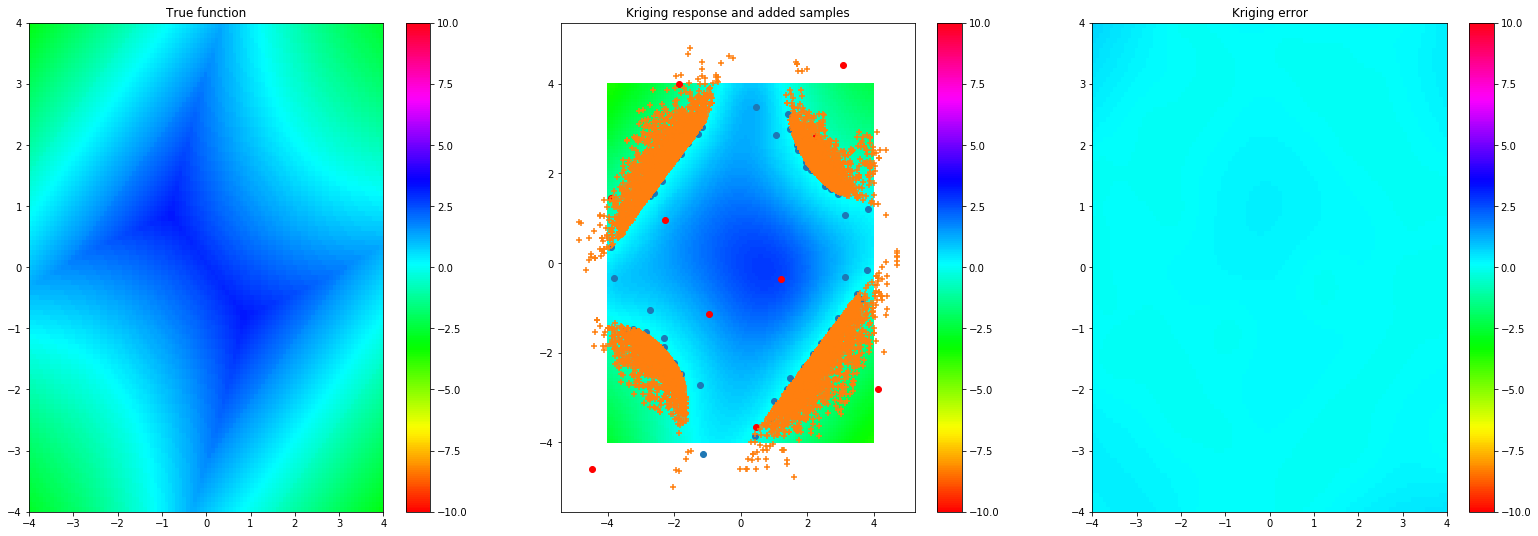

In [24]:
#Plot of surrogate model
import matplotlib.pyplot as plt

grid_size = 100
x1 = np.linspace(-4,4,grid_size)
x2 = np.linspace(-4,4,grid_size)

xx1,xx2 = np.meshgrid(x1,x2)

xx1_ = xx1.reshape((grid_size**2,1))
xx2_ = xx2.reshape((grid_size**2,1))

x = np.concatenate((xx1_,xx2_),1)
                  
y_true = np.array(my_four_branch_7(x))
y_mean_krig =np.array(kr.getConditionalMean(x))     
                   
y_sigma_krig = np.array(np.sqrt(kr.getConditionalMarginalVariance(x)))

y_true = y_true.reshape((grid_size,grid_size))
y_mean_krig = y_mean_krig.reshape((grid_size,grid_size))
y_sigma_krig= y_sigma_krig.reshape((grid_size,grid_size))

cmap = mpl.cm.hsv
norm = mpl.colors.Normalize(vmin=-10, vmax=10)
%matplotlib inline 
fig, (ax0, ax1,ax2) = plt.subplots(ncols=3,figsize=(27,9))
im1 = ax0.pcolormesh(xx1,xx2,y_true,norm = norm,cmap = cmap)
fig.colorbar(im1, ax=ax0)
ax0.title.set_text('True function')

im2 = ax1.pcolormesh(xx1,xx2,y_mean_krig,norm = norm,cmap = cmap)
ax1.scatter(DoE_four_branch_x[0:my_AK_four_branch.n_DoE,0],DoE_four_branch_x[0:my_AK_four_branch.n_DoE,1],color = 'r')
ax1.scatter(DoE_four_branch_x[my_AK_four_branch.n_DoE:,0],DoE_four_branch_x[my_AK_four_branch.n_DoE:,1])

ax1.scatter(np.array(ss_samples)[:,0],np.array(ss_samples)[:,1],marker  = '+')

fig.colorbar(im2, ax=ax1)
ax1.title.set_text('Kriging response and added samples')

im3 = ax2.pcolormesh(xx1,xx2,y_sigma_krig,norm = norm,cmap = cmap)
fig.colorbar(im3, ax=ax2)
ax2.title.set_text('Kriging error')

## Experiment 3 : "Non linear oscillator"

$G(c_1,c_2,m,r,t_1,F_1)  = 3r-\left|\frac{2 F_1}{m \omega_0^2}sin\left(\frac{\omega_0 t_1}{2}\right)\right|$

with : 
* $\omega_0 = \sqrt{\left(\frac{c_1+c_2}{m}\right)}$
* $m \sim \mathcal{N}(1,0.05)$
* $c_1 \sim \mathcal{N}(1,0.1)$
* $c_2 \sim \mathcal{N}(0.1,0.01)$
* $r \sim \mathcal{N}(0.5,0.05)$
* $F_1 \sim \mathcal{N}(1.,0.2)$
* $r \sim \mathcal{N}(1.,0.2)$

### Definition of input variable probability distributions

In [25]:
dist_c1=ot.Normal(1, 0.1)
dist_c2=ot.Normal(0.1, 0.01)
dist_m=ot.Normal(1.,0.05 )
dist_r =ot.Normal(0.5, 0.05)
dist_t1 =ot.Normal(1., 0.2)
dist_F1=ot.Normal(1., 0.2)
std_dev = [dist_c1.getStandardDeviation()[0],dist_c2.getStandardDeviation()[0],dist_m.getStandardDeviation()[0],
           dist_r.getStandardDeviation()[0],dist_t1.getStandardDeviation()[0],dist_F1.getStandardDeviation()[0]]
dim_inputs=6
marginals = [dist_c1,dist_c2,dist_m,dist_r,dist_t1,dist_F1]
dist_x = ot.ComposedDistribution(marginals)


### Definition of model

In [28]:
#Definition of classical function
def non_lin_osc(x):
    c1 = x[0]
    c2  = x[1]
    m = x[2]
    r = x[3]
    t1 = x[4]
    F1= x[5]
    
    omega = np.sqrt((c1+c2)/m)
    
    G = 3*r - np.abs(2*F1/(m*omega**2)*np.sin(omega*t1/2))
    return [G]

# Definition of python function
non_lin_osc = ot.PythonFunction(6, 1, non_lin_osc)

# Creation of event
vect = ot.RandomVector(dist_x)
G = ot.CompositeRandomVector(non_lin_osc, vect)
event_osc = ot.ThresholdEvent(G, ot.Less(), 0.0)

### Estimation of reference probability with Monte Carlo

In [29]:
n_MC = np.int(1e4)
# create a Monte Carlo algorithm
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event_osc, experiment)
algo.setMaximumOuterSampling(int(n_MC))
algo.setMaximumCoefficientOfVariation(0.01)

algo.run()

# retrieve results
result = algo.getResult()
probability = result.getProbabilityEstimate()
print('Failure probability', probability)
print('Coefficient of variation', result.getCoefficientOfVariation())

Failure probability 0.027799999999999988
Coefficient of variation 0.05913647184401739


## Definition of AK SS experiment

In [30]:
# Definition of Kriging model
dim_osc = 6

basis = ot.ConstantBasisFactory(dim_osc).build()
covarianceModel = ot.SquaredExponential([0.1]*dim_osc, [1.0])
n_MC_osc = 1000
n_DoE_osc = 40
sim_budget_osc = 200
verbose = True
criterion = 2
proposal_range = 1.
target_proba=0.1
cv_target = 0.05
my_AK_non_lin_osc = AK_SSAlgorithm(event_osc,
                                    n_MC_osc,
                                    n_DoE_osc,
                                    sim_budget_osc,
                                    basis,
                                    covarianceModel,
                                    proposal_range,
                                    target_proba,
                                    cv_target,
                                    criterion,
                                    verbose)

## Computation of failure probability

In [31]:
#computation of probability with AK-MCS
my_AK_non_lin_osc.compute_proba()

D:\mbalesde\Logiciels\Externes\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in sqrt


current_iter | Nb_sim  | Probability estimate  | Coefficient of variation
        1    |      1  |       2.700000e-02    |       1.209814e-01
        2    |      5  |       2.915000e-02    |       7.320700e-02
        3    |      5  |       3.243333e-02    |       5.995608e-02
        4    |      6  |       3.087500e-02    |       5.401445e-02
        5    |      7  |       2.950000e-02    |       4.753384e-02


In [32]:
print('Probability of failure:',my_AK_non_lin_osc.getFailureProbability())
print('Coefficient of variation:',my_AK_non_lin_osc.getCoefficientOfVariation())
print('Simulation budget:',my_AK_non_lin_osc.getSimBudget())

Probability of failure: 0.02950000000000003
Coefficient of variation: 0.04753383711404174
Simulation budget: 47
